In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load dataset
data = pd.read_csv('temp.csv')

target = 'loadConsumption'

feature_sets = {
    "Exogenous Features": [
        'DailyMeanTemperature', 'DailyMeanWindspeed', 'DailyPrecipitation', 'day_of_week',
        'AveragePrice_Electricity_Household', 'AveragePrice_NaturalGas_Household',
        'Economic_Component', 'RenewableEnergy_Component'
    ],
    "Generated Features": [
        'is_weekend', 'is_holiday', 'day_of_year', 'rolling_7', 'rolling_30', 'rolling_365'
    ],
    "Both Exogenous & Generated": [
        'DailyMeanTemperature', 'DailyMeanWindspeed', 'DailyPrecipitation', 'day_of_week',
        'AveragePrice_Electricity_Household', 'AveragePrice_NaturalGas_Household',
        'Economic_Component', 'RenewableEnergy_Component',
        'is_weekend', 'is_holiday', 'day_of_year', 'rolling_7', 'rolling_30', 'rolling_365'
    ]
}

# Train-test split
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

forecast_horizons = [1, 7, 30, 90, 180]
results_summary = {}

# Helper function: create LSTM sequences
def create_sequences(data, n_steps=30):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Iterate over each feature set
for name, features in feature_sets.items():
    results_summary[name] = {}

    for horizon in forecast_horizons:
        print(f"Evaluating: {name}, {horizon}-day horizon")

        # ---- Stage 1: SARIMAX ----
        sarimax_model = SARIMAX(train_data[target],
                                exog=train_data[features],
                                order=(2, 0, 3),
                                seasonal_order=(1, 0, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
        sarimax_results = sarimax_model.fit(disp=False)

        # Predict on training data to get residuals
        train_pred_sarimax = sarimax_results.predict(
            start=train_data.index[0], end=train_data.index[-1],
            exog=train_data[features], dynamic=False)

        train_residuals = train_data[target] - train_pred_sarimax

        # ---- Stage 2: LSTM on Residuals ----
        scaler = MinMaxScaler()
        train_residuals_scaled = scaler.fit_transform(train_residuals.values.reshape(-1, 1))

        n_steps = 30
        X_train, y_train = create_sequences(train_residuals_scaled, n_steps)

        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

        # Forecast SARIMAX on test data
        sarimax_forecast = sarimax_results.forecast(steps=horizon, exog=test_data[features].iloc[:horizon])
        test_actual = test_data[target].iloc[:horizon].values

        # Residuals for LSTM prediction
        test_residuals = test_actual - sarimax_forecast.values
        test_residuals_scaled = scaler.transform(test_residuals.reshape(-1, 1))

        # LSTM Forecasting: use last sequence from training
        if len(train_residuals_scaled) >= n_steps:
            last_sequence = train_residuals_scaled[-n_steps:]
            lstm_input = last_sequence.reshape((1, n_steps, 1))
            lstm_preds_scaled = []

            for _ in range(horizon):
                pred = model.predict(lstm_input, verbose=0)
                lstm_preds_scaled.append(pred[0, 0])
                lstm_input = np.append(lstm_input[:, 1:, :], [[[pred[0, 0]]]], axis=1)

            lstm_preds_scaled = np.array(lstm_preds_scaled).reshape(-1, 1)
            lstm_preds = scaler.inverse_transform(lstm_preds_scaled).flatten()
        else:
            lstm_preds = np.zeros(horizon)

        # Combine predictions
        combined_forecast = sarimax_forecast.values + lstm_preds

        # Evaluation
        rmse = np.sqrt(mean_squared_error(test_actual, combined_forecast))
        mae = mean_absolute_error(test_actual, combined_forecast)
        mean_actual = np.mean(test_actual)
        mape = np.mean(np.abs((test_actual - combined_forecast) / test_actual)) * 100

        results_summary[name][f"{horizon}-Day"] = {
            "nRMSE": rmse / mean_actual,
            "nMAE": mae / mean_actual,
            "MAPE (%)": mape
        }

# Convert to DataFrame
results_df = pd.concat({k: pd.DataFrame(v).T for k, v in results_summary.items()})
results_df.index.names = ['Feature Set', 'Forecast Horizon']
print("\nFinal Results:\n")
print(results_df.round(4))

Evaluating: Exogenous Features, 1-day horizon
Evaluating: Exogenous Features, 7-day horizon
Evaluating: Exogenous Features, 30-day horizon
Evaluating: Exogenous Features, 90-day horizon
Evaluating: Exogenous Features, 180-day horizon
Evaluating: Generated Features, 1-day horizon


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating: Generated Features, 7-day horizon


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating: Generated Features, 30-day horizon


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating: Generated Features, 90-day horizon


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating: Generated Features, 180-day horizon


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating: Both Exogenous & Generated, 1-day horizon


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating: Both Exogenous & Generated, 7-day horizon


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating: Both Exogenous & Generated, 30-day horizon


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating: Both Exogenous & Generated, 90-day horizon


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluating: Both Exogenous & Generated, 180-day horizon


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Final Results:

                                              nRMSE    nMAE  MAPE (%)
Feature Set                Forecast Horizon                          
Exogenous Features         1-Day             0.0043  0.0043    0.4270
                           7-Day             0.0869  0.0674    6.7469
                           30-Day            0.1397  0.1253   12.2436
                           90-Day            0.1603  0.1493   14.7161
                           180-Day           0.1213  0.1027    9.8916
Generated Features         1-Day             0.0413  0.0413    4.1272
                           7-Day             0.0690  0.0662    6.7008
                           30-Day            0.0491  0.0427    4.3284
                           90-Day            0.0365  0.0288    2.9087
                           180-Day           0.0418  0.0333    3.3806
Both Exogenous & Generated 1-Day             0.0405  0.0405    4.0509
                           7-Day             0.0758  0.0723    7.3223
   

In [3]:
results_df

nRMSE      nMAE   MAPE (%)
Feature Set                Forecast Horizon                               
Exogenous Features         1-Day             0.004270  0.004270   0.427010
                           7-Day             0.086916  0.067359   6.746905
                           30-Day            0.139721  0.125349  12.243606
                           90-Day            0.160302  0.149326  14.716080
                           180-Day           0.121309  0.102697   9.891563
Generated Features         1-Day             0.041272  0.041272   4.127191
                           7-Day             0.068965  0.066214   6.700820
                           30-Day            0.049147  0.042684   4.328410
                           90-Day            0.036480  0.028846   2.908655
                           180-Day           0.041777  0.033272   3.380614
Both Exogenous & Generated 1-Day             0.040509  0.040509   4.050907
                           7-Day             0.075766  0.072349   7.322278
                           30-Day            0.048777  0.039450   4.060175
                           90-Day            0.037305  0.028833   2.918632
                           180-Day           0.038378  0.030905   3.133974

In [4]:
# Convert to percentages
results_df['nRMSE'] = results_df['nRMSE'] * 100
results_df['nMAE'] = results_df['nMAE'] * 100

# Round the values
results_df = results_df.round(3)

# Display
results_df


nRMSE    nMAE  MAPE (%)
Feature Set                Forecast Horizon                          
Exogenous Features         1-Day              0.427   0.427     0.427
                           7-Day              8.692   6.736     6.747
                           30-Day            13.972  12.535    12.244
                           90-Day            16.030  14.933    14.716
                           180-Day           12.131  10.270     9.892
Generated Features         1-Day              4.127   4.127     4.127
                           7-Day              6.896   6.621     6.701
                           30-Day             4.915   4.268     4.328
                           90-Day             3.648   2.885     2.909
                           180-Day            4.178   3.327     3.381
Both Exogenous & Generated 1-Day              4.051   4.051     4.051
                           7-Day              7.577   7.235     7.322
                           30-Day             4.878   3.945     4.060
                           90-Day             3.730   2.883     2.919
                           180-Day            3.838   3.091     3.134

In [8]:
# Rename columns
results_df.rename(columns={'nRMSE': 'nRMSE%', 'nMAE': 'nMAE%'}, inplace=True)


In [12]:
# Reshape the DataFrame so feature sets become columns
pivot_df = results_df.unstack(level=0)

# Optional: flatten MultiIndex column names for clarity
pivot_df.columns = [' '.join(col).strip() for col in pivot_df.columns]

# Display the new structure
pivot_df


,nRMSE% Exogenous Features,nRMSE% Generated Features,nRMSE% Both Exogenous & Generated,nMAE% Exogenous Features,nMAE% Generated Features,nMAE% Both Exogenous & Generated,MAPE (%) Exogenous Features,MAPE (%) Generated Features,MAPE (%) Both Exogenous & Generated
Forecast Horizon,,,,,,,,,
1-Day,0.427,4.127,4.051,0.427,4.127,4.051,0.427,4.127,4.051
7-Day,8.692,6.896,7.577,6.736,6.621,7.235,6.747,6.701,7.322
30-Day,13.972,4.915,4.878,12.535,4.268,3.945,12.244,4.328,4.060
90-Day,16.030,3.648,3.730,14.933,2.885,2.883,14.716,2.909,2.919
180-Day,12.131,4.178,3.838,10.270,3.327,3.091,9.892,3.381,3.134


In [14]:
results_df

nRMSE%   nMAE%  MAPE (%)
Feature Set                Forecast Horizon                          
Exogenous Features         1-Day              0.427   0.427     0.427
                           7-Day              8.692   6.736     6.747
                           30-Day            13.972  12.535    12.244
                           90-Day            16.030  14.933    14.716
                           180-Day           12.131  10.270     9.892
Generated Features         1-Day              4.127   4.127     4.127
                           7-Day              6.896   6.621     6.701
                           30-Day             4.915   4.268     4.328
                           90-Day             3.648   2.885     2.909
                           180-Day            4.178   3.327     3.381
Both Exogenous & Generated 1-Day              4.051   4.051     4.051
                           7-Day              7.577   7.235     7.322
                           30-Day             4.878   3.945     4.060
                           90-Day             3.730   2.883     2.919
                           180-Day            3.838   3.091     3.134

In [13]:
results_df.to_csv('results\sarimax_lstm_results.csv', index = False)

In [16]:
results_df

nRMSE%   nMAE%  MAPE (%)
Feature Set                Forecast Horizon                          
Exogenous Features         1-Day              0.427   0.427     0.427
                           7-Day              8.692   6.736     6.747
                           30-Day            13.972  12.535    12.244
                           90-Day            16.030  14.933    14.716
                           180-Day           12.131  10.270     9.892
Generated Features         1-Day              4.127   4.127     4.127
                           7-Day              6.896   6.621     6.701
                           30-Day             4.915   4.268     4.328
                           90-Day             3.648   2.885     2.909
                           180-Day            4.178   3.327     3.381
Both Exogenous & Generated 1-Day              4.051   4.051     4.051
                           7-Day              7.577   7.235     7.322
                           30-Day             4.878   3.945     4.060
                           90-Day             3.730   2.883     2.919
                           180-Day            3.838   3.091     3.134

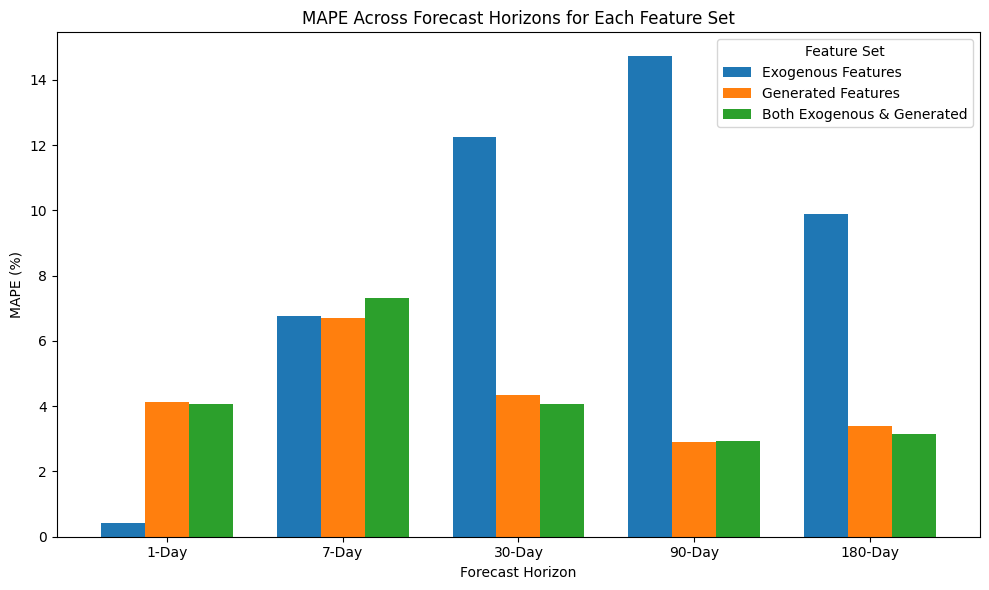

In [18]:
import matplotlib.pyplot as plt

# Unstack to get Feature Sets as columns, Forecast Horizons as rows
mape_df = results_df['MAPE (%)'].unstack(level=0)

# Optional: sort forecast horizons in logical order
ordered_horizons = ['1-Day', '7-Day', '30-Day', '90-Day', '180-Day']
mape_df = mape_df.loc[ordered_horizons]

# Plot
ax = mape_df.plot(kind='bar', figsize=(10, 6), width=0.75)
plt.title('MAPE Across Forecast Horizons for Each Feature Set')
plt.ylabel('MAPE (%)')
plt.xlabel('Forecast Horizon')
plt.xticks(rotation=0)
plt.legend(title='Feature Set')
plt.tight_layout()

plt.savefig('plots\mapeComparison_darimax_lstm1.png', dpi=300)

plt.show()